<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/traffic_forecast_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metro Interstate Traffic Volume Forecasting (Part 2)
This notebook is based on chapter 13 of the book [*Time Series Forecasting in Python*](https://www.manning.com/books/time-series-forecasting-in-python-book) by Marco Peixeiro. Classical algorithms for time series forecasting, are

* $Moving Average MA(q)$
* $Auto Regressive AR(p)$
* $Autoregressive Moving Average ARMA(p,q)$
* $Autoregressive Integrated Moving Average ARIMA(p,d,q)$
* $SARIMA(p,d,q)(P,D,Q)_m$
* $SARIMAX$

where q is the order, or lag, of the time series, that is the number of previous elements in the series that are used for the forecast, p is the autocorrelation order, that is number of elements that are correlated, P and Q are the seasonal lag and autocorrelation order. These models try to fit a set of basis functions to the data depending on the chosen order $(p,d,q)(P,D,Q)_m$. With the neural networks we fit an unknown nonlinear function to the data.


In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import keras
from keras import layers
print('NumPy version: %s'%np.__version__)
print('Pandas version: %s'%pd.__version__)
print('Matplotlib version: %s'%mpl.__version__)
print('TensorFlow version: %s'%tf.__version__)
print('Keras version: %s'%keras.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.10.0
TensorFlow version: 2.18.0
Keras version: 3.8.0


## Data windowing
In order to train a model we split the data into time windows of the same length, for instance 24 hours. If the task is multistep forecasting, we use e.g. 24 hours as input data and the next 24 hours as target values so that a data window contains 48 hours. For example, the 1st window uses 48 hours starting from the 1st hour, the 2nd window uses 48 hours starting from the 2nd hour and so on. So there is an overlap of 47 hours between two consecutive data windows. We can create batches using a certain number of data windows, e.g. 32 data windows. The order for each data window cannot be changed but the order of the data windows in a batch can be shuffled.

In [2]:
def download_data(url):
  r = requests.get(url)
  data_path = url.rsplit('/')[-1]
  with open(data_path, 'wb') as f:
    f.write(r.content)
  return data_path

In [3]:
train_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/train.csv'
val_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/val.csv'
test_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/test.csv'
train_data = download_data(train_url)
val_data = download_data(val_url)
test_data = download_data(test_url)
train_df = pd.read_csv(train_data, index_col=0)
val_df = pd.read_csv(val_data, index_col=0)
test_df = pd.read_csv(test_data, index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [4]:
train_df.columns

Index(['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos'], dtype='object')

The input features are: cloud_all, day_sin, and day_cos. The label features are: temp, and traffic_volume

In [5]:
day_enum = ['Friday',
            'Saturday',
            'Sunday',
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday',
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday']

len(day_enum)

17

We can see the 48 hours data windows within the first 400 hours in our dataset, with square markers and blu color used for the 24 inputs of each data window, and cross markers and red color used for the labels.

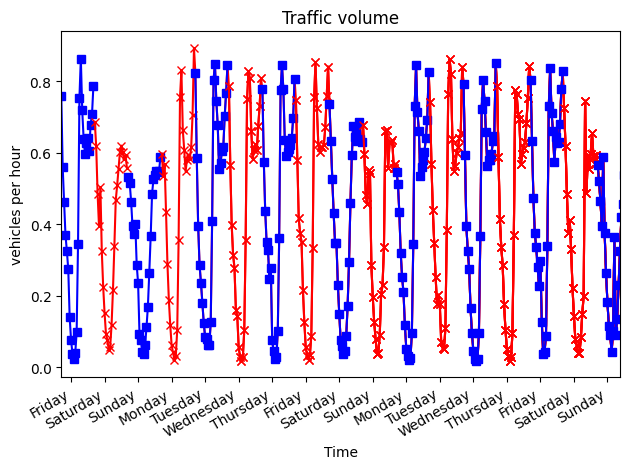

In [6]:
fig, ax = plt.subplots()
fig.autofmt_xdate()

for n in range(0, 17, 2):
    start = 24 * n
    stop = 24 * (n + 1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')

ax.set_title('Traffic volume')
ax.set_xlabel('Time')
ax.set_ylabel('vehicles per hour')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

## Deep learning model
Deep learning model might perform better than classical time series models when the dataset available is large and contains signals that are complex. For example SARIMAX can be used only when there is only one kind of seasonality or cycle. In general deep learning model can be used when there is some nonlinear relationship between the input, in our example the meteorological variables and holidays and the target.

## The data window
The DataWindow class will use the train, validation, and test set by default. It has four arguments to be passed to create an instance: the inputs width, in our example 24, the labels width, also 24 in our example, the shift that is also 24 in case of multistep prediction, and the name of the label column in the training, validation, and test sets. The DataWindow class creates batches of windows of inputs and labels by sliding through the dataset. The DataWindow make_dataset() function that creates the batches is based on the [timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) function from TensorFlow. The size of each batch is set to 32 so the number of batches depends on the number of observations in the train, validation, and test datasets

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        '''
        This function separates inputs and labels from the features.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        The function plots the model's predictions for three data windows
        '''
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        '''
        This function is based on a Keras function to create batches of data by sliding windows of inputs and lables from the train, validation, and test sets.
        The slide is set with the sequence_stride argument and it is set to 1. The data windows are shuffled but the order within each window is preserved.
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## Single-step baseline model
To begin with, we use the DataWindow class to train a single-step model to predict the value of a target variable, e.g. the traffic volume, only one step in the future using an input with only one value. In this case the length of each window in the training set is 2, one for the input and one for the label.  

In [8]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])

We create also a window of size 24 for plotting purposes

In [9]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

We create a custom baseline model by subclassing the [Keras Model](https://keras.io/api/models/model/) class. With only one input value the best prediction we can make is simply to return the same input value. So there's no need to train the model.

In [10]:
class Baseline(keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

In [12]:
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

We configure the loss function as the mean squared error ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)), and the metric as the mean absolute error ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)) using the compile method of the Keras Model class

In [13]:
baseline_last.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

In [14]:
baseline_last.summary()


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

We assess the performance of the baseline model against the validation and the test set

In [15]:
val_performance = {}
performance = {}
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136 - mean_absolute_error: 0.0834


We call the plot method of the wide window passing the baseline model that contains the computes predictions. By default the method plots the predictions for three data windows.  

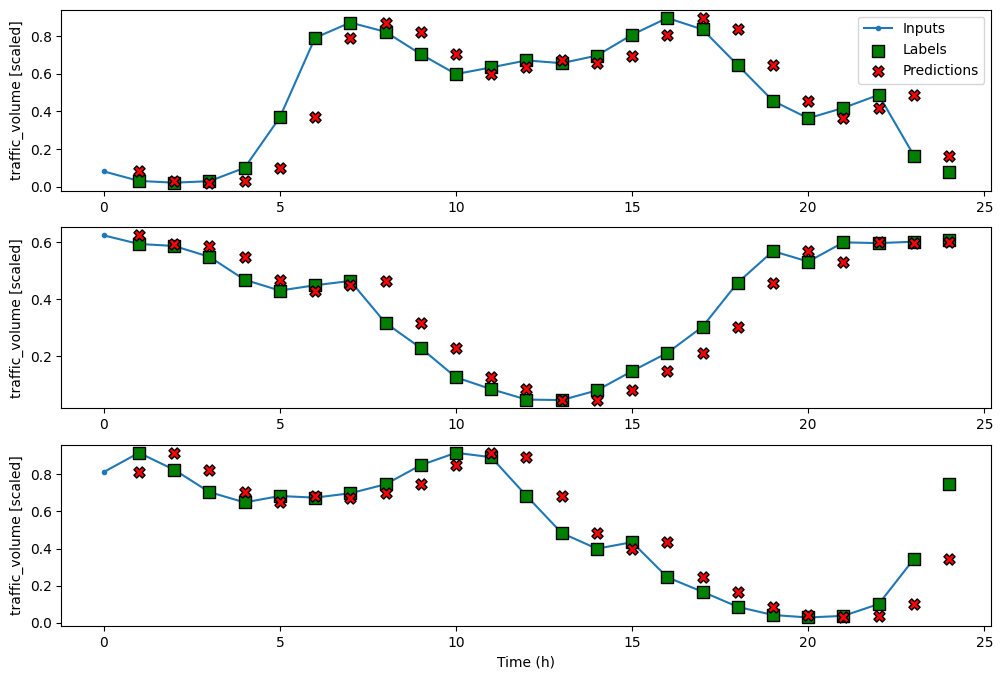

In [16]:
wide_window.plot(baseline_last)

In [17]:
print('MAE on the test set: {:.2f}'.format(performance['Baseline - Last'][1]))

MAE on the test set: 0.08


## Multi-step baseline model
Now we want to forecast more that one step in the future. For example, the next 24 hours using 24 hours of observations as input. The data window is 24 input values, 24 labels with a shift that is the same length as the labels.

In [18]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

We want to build a baseline model for multi-step prediction that we will use to assess the performance of the deep learning models. The most basic multi-step, say 24 step, baseline model is the model that simply returns the last input value 24 times. Another simple multi-step model is the model that returns the last 24 input values. There is no need to train these baseline models.  

In [19]:
class MultiStepLastBaseline(keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) # returns tha last 24 values
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1]) # returns tha last value 24 times

We start with the multi-step baseline model that returns as the prediction only the last value of the 24 labels

In [20]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

As for the single-step model, we configure the multi-step model by setting the loss function and the metric

In [21]:
ms_baseline_last.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

In [22]:
ms_baseline_last.summary()

Model: "multi_step_last_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

We evaluate the performance of the multi-step baseline model against the validation and the test set

In [23]:
ms_val_performance = {}
ms_performance = {}
ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1880 - mean_absolute_error: 0.3525


We plot the data and the predictions for three data windows

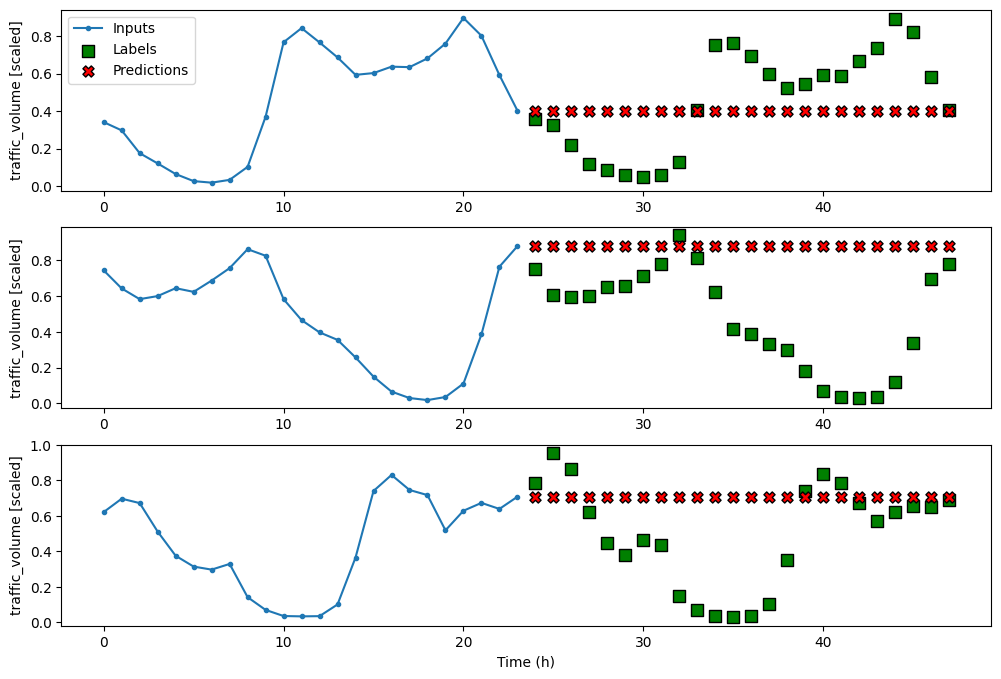

In [24]:
multi_window.plot(ms_baseline_last)

We can also print the Mean Absolute Error of the predictions that is obviously high.

In [25]:
print('MAE on the test set: {:.3f}'.format(ms_performance['Baseline - Last'][1]))

MAE on the test set: 0.347


Now we create a multi-step baseline model that predicts the same input values

In [26]:
class RepeatBaseline(keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [27]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_repeat.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1892 - mean_absolute_error: 0.3267


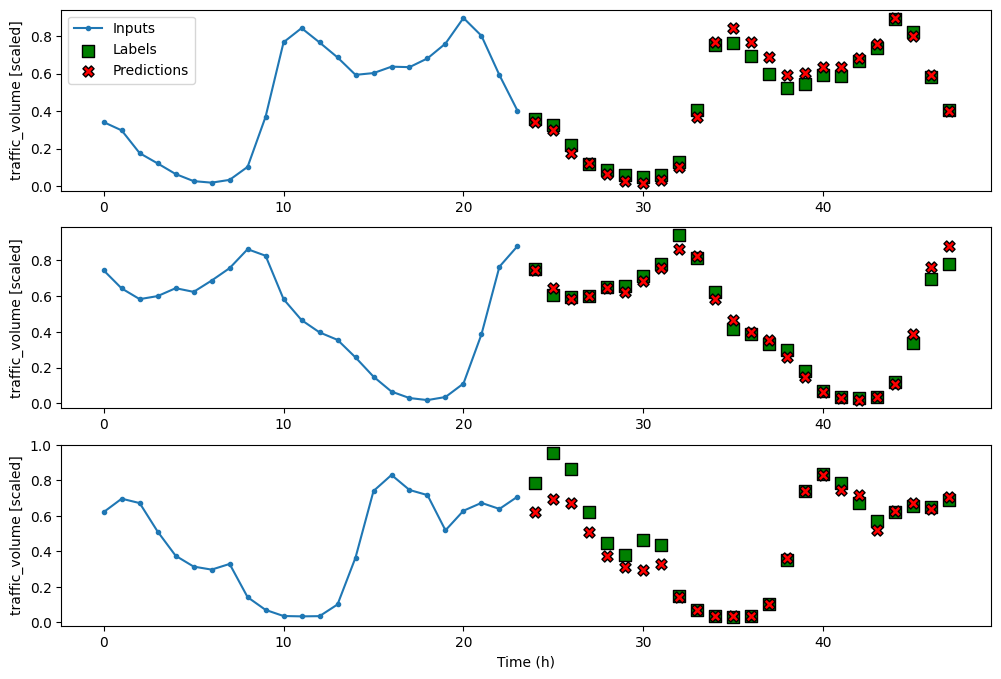

In [28]:
multi_window.plot(ms_baseline_repeat)

We can see that the mean absolute error is lower for this baseline model than for the previous one.

In [29]:
print('MAE on the test set: {:.3f}'.format(ms_performance['Baseline - Repeat'][1]))

MAE on the test set: 0.315


## Multi-output single-step baseline model
Now we build a baseline model to predict more than one target variable, for instance the traffic volume and the temperature. The model will predict one single value using only one input value. We create two data windows, one for model and another one (multi-step) for plotting purposes.

In [30]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [31]:
mo_baseline_last = Baseline(label_index=[0, 2])
mo_baseline_last.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

In [32]:
mo_val_performance = {}
mo_performance = {}
mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0481


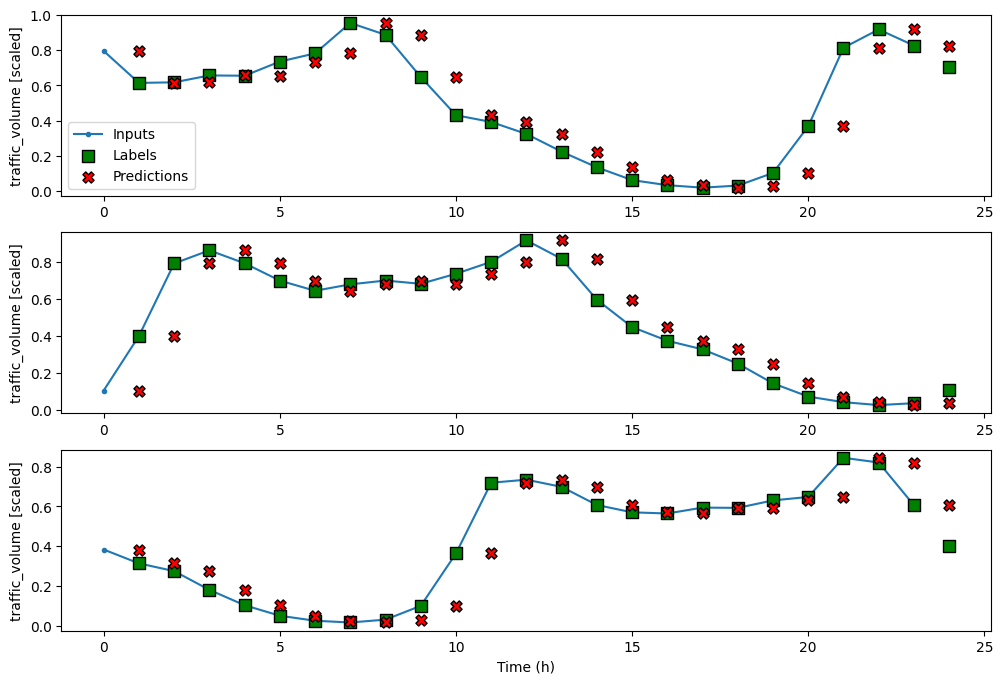

In [33]:
mo_wide_window.plot(mo_baseline_last)

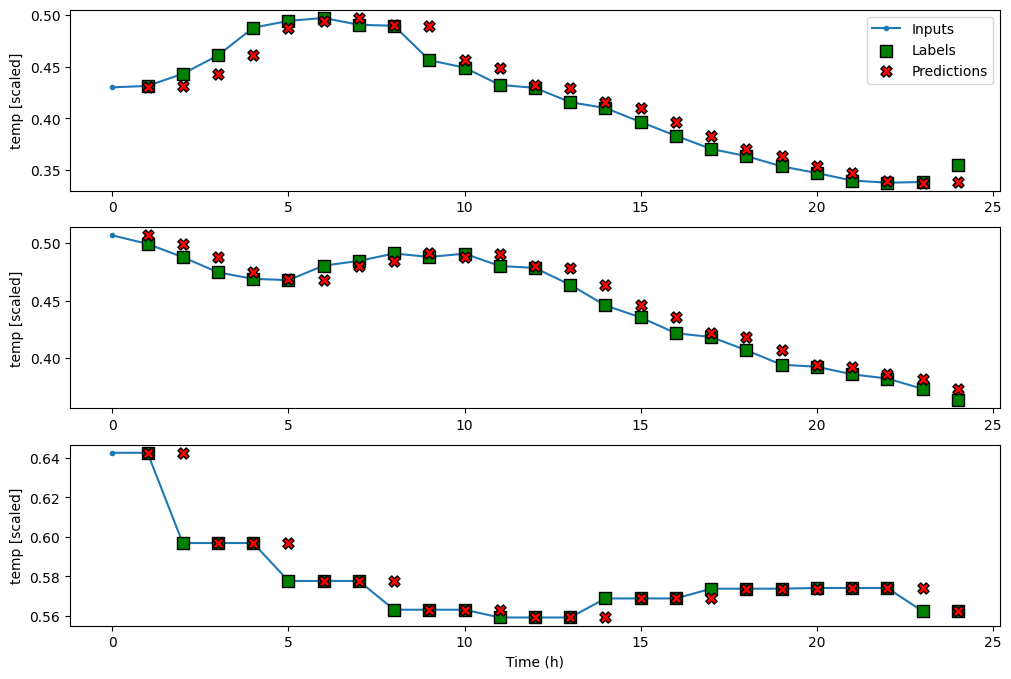

In [34]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [35]:
print('MAE against the test set\nTraffic volume: {0:.3f}\nTemperature: {1:.3f}'.format(mo_performance['Baseline - Last'][0], mo_performance['Baseline - Last'][1]))

MAE against the test set
Traffic volume: 0.006
Temperature: 0.047


## Single-step linear model
We build a multilinear model to predict the traffic volume in a single step. We use as inputs all the 5 features of our dataset at time $t$ to predict one of them, the traffic volume, at time $t + 1$.



In [36]:
train_df.columns

Index(['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos'], dtype='object')

a linear model is defined as a weighted sum of the features value

$$x_{2, t+1} = w_1 x_{1,t} + w_2 x_{2,t} + w_3 x_{3,t} + w_4 x_{4,t} + w_5 x_{5,t}$$

The weights $w_i$ must be estimated from the data by minimizing the mean squared error between the prediction and the actual value of the traffic volume. We build the model using the Keras Sequential model with a Dense, fully connected, layer with a single unit with 5 inputs, one output, and without activation function. We will set the loss function and the performance metric as we did for the baseline model but this time we will use the data to train the model.

In [37]:
linear_model = keras.Sequential([
    layers.Dense(units=1)
])

We define a function to set the loss function and the performance metric, and to compile and fit the data.

In [39]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  metrics=[keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

We train the linear model for 50 epochs. With the patience set to 3 the training will stop if there is no improvement after three epochs in a row.

In [51]:
history = compile_and_fit(linear_model, single_step_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - mean_absolute_error: 0.0677 - val_loss: 0.0090 - val_mean_absolute_error: 0.0661
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0093 - mean_absolute_error: 0.0676 - val_loss: 0.0091 - val_mean_absolute_error: 0.0654
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - mean_absolute_error: 0.0678 - val_loss: 0.0091 - val_mean_absolute_error: 0.0651
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - mean_absolute_error: 0.0677 - val_loss: 0.0091 - val_mean_absolute_error: 0.0650


In [58]:
val_performance['Linear'] = linear_model.evaluate(single_step_window.val)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - mean_absolute_error: 0.0630


In [60]:
performance['Linear'] = linear_model.evaluate(single_step_window.test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - mean_absolute_error: 0.0628


In [42]:
linear_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1, 1)                │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20 (84.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14 (60.00 B)

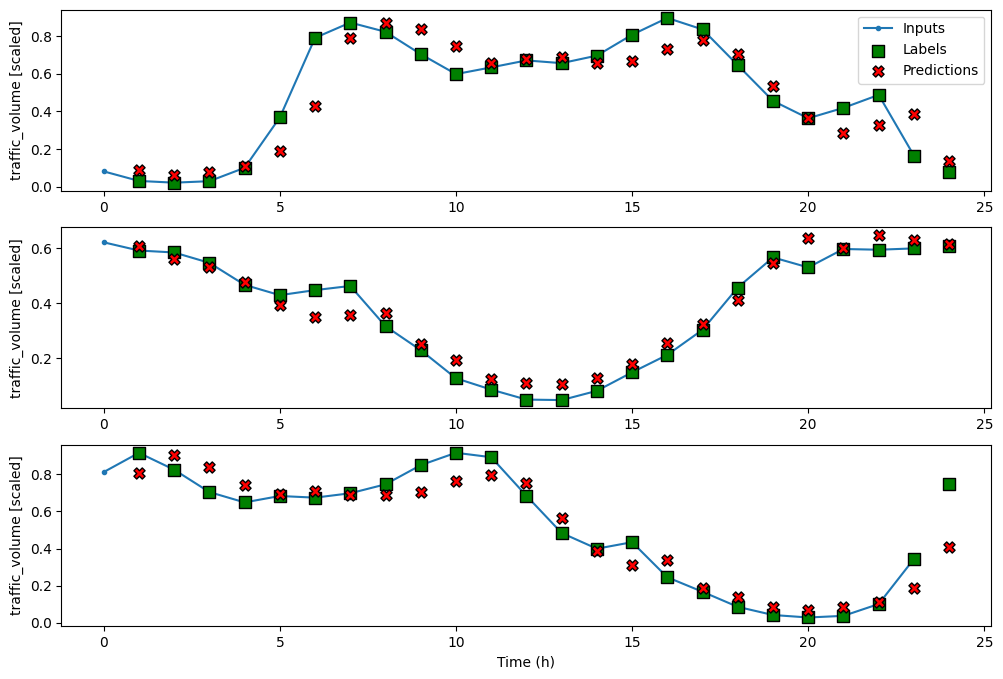

In [41]:
wide_window.plot(linear_model)

## Multi-step linear model
For the multi-step linear model we will use 24 values of each feature as input of a Dense layer with a single unit with 5 inputs, again without activation function, and one output for the same target variable, the traffic volume. From the point of view of the architecture, the multi-step linear model is the same as the single-step linear model, the only difference is that it will use 24 values, one by one, of each features to compute 24 values of the target variables. The model doesn't consider any dependence between two adjacent values of a features.    

In [44]:
ms_linear_model = keras.Sequential([
    layers.Dense(1, kernel_initializer=tf.initializers.zeros)
])

In [45]:
history = compile_and_fit(ms_linear_model, multi_window)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1411 - mean_absolute_error: 0.3089 - val_loss: 0.0404 - val_mean_absolute_error: 0.1669
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0327 - mean_absolute_error: 0.1474 - val_loss: 0.0238 - val_mean_absolute_error: 0.1193
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0207 - mean_absolute_error: 0.1103 - val_loss: 0.0206 - val_mean_absolute_error: 0.1064
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0180 - mean_absolute_error: 0.0992 - val_loss: 0.0195 - val_mean_absolute_error: 0.1007
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0170 - mean_absolute_error: 0.0938 - val_loss: 0.0189 - val_mean_absolute_error: 0.0967
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0165 - mean_absolute_error: 0.0901 - val_loss: 0.0185 - val_mean_absolute_error: 0.0931
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0161 - mean_absolute_error: 0.0874 -

In [47]:
ms_linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 24, 1)               │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20 (84.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14 (60.00 B)

In [54]:
ms_val_performance['Linear'] = ms_linear_model.evaluate(multi_window.val)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - mean_absolute_error: 0.0888


In [57]:
ms_performance['Linear'] = ms_linear_model.evaluate(multi_window.test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0744


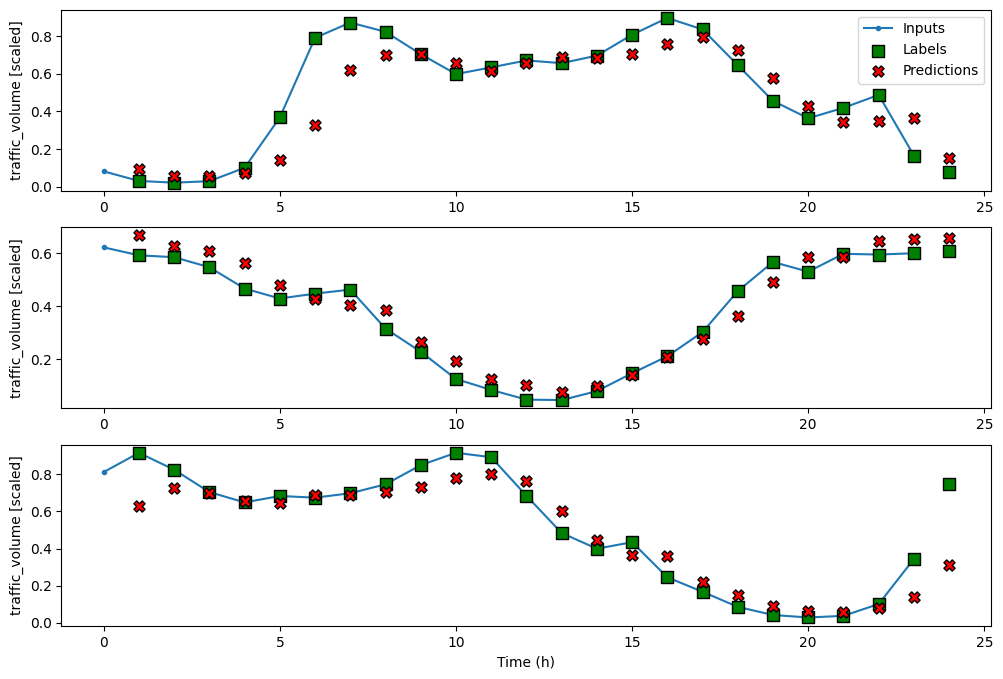

In [48]:
wide_window.plot(ms_linear_model)

## Multi-output single-step linear model
This model will return the predictions of two target variables, in our example the traffic volume and the temperature.